# Sinais de excitação

Neste notebook avaliamos diferentes sinais usados em medições de Sistemas Lineares e Invariantes no tempo.

- Sweeps linear e logarítmico
- Ruído branco
- Ruído rosa (ou coloridos)
- MLS

In [1]:
# importar as bibliotecas necessárias
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
plt.rcParams.update({'font.size': 14})
from scipy import signal
import IPython.display as ipd # to play signals
import sounddevice as sd
import soundfile as sf

In [2]:
def plot_signal(xt, fs = 44100, t_max = 5):
    """ Function to plot x(t) vs. time, auto-spectrum and spectogram
    
    Parameters:
    --------------------
    xt : numpy 1darray
        the signal in time (sequence) dommain
    fs : int
        the number of samples per second of the time singal (sampling rate)
    t_max : float
        the maximum time to display the signal in the graph
    """
    # time vector
    t = np.arange(0, (len(xt))/fs, 1/fs)
    # Auto-spectrum
    win_size = 8192
    win = signal.windows.hann(win_size)
    noverlap = win_size/2
    nfft = win_size
    freq, Sxx = signal.csd(xt, xt, fs, window = win, noverlap = noverlap, nfft = nfft, scaling = 'spectrum')
    Sxx_dB = 10*np.log10(Sxx/np.amax(Sxx))
    
    # spectogram
    f_frame, t_frame, S_spec = signal.spectrogram(xt, fs, window = win, noverlap = noverlap, scaling = 'spectrum')
    
    fig, axs = plt.subplots(1, 3, figsize = (16, 4))
    axs[0].plot(t, xt, '-b', linewidth = 1, alpha = 0.7)
    axs[0].grid(linestyle = '--', which='both')
    axs[0].set_xlabel('Tempo [s]')
    axs[0].set_ylabel('Amplitude [-]')
    axs[0].set_xlim((0, t_max))
    axs[0].set_ylim((1.2*np.amin(xt), 1.2*np.amax(xt)))
    
    axs[1].semilogx(freq, Sxx_dB, linewidth = 2, color = 'b', alpha = 0.7)
    axs[1].grid(linestyle = '--', which='both')
    axs[1].set_ylabel(r'$E[|X(j\omega)|^2] [dB]$')
    axs[1].set_xlabel('Frequência [Hz]')
    axs[1].set_xlim((10, fs/2))
    #axs[1].set_ylim((np.amin(Sxx_dB)-20, np.amax(Sxx_dB)+10))
    axs[1].set_ylim(-50, +10)
    
    p = plt.pcolormesh(t_frame, f_frame, 10*np.log10(S_spec/np.amax(S_spec)), shading='gouraud', vmin = -50)
    plt.colorbar(p)
    axs[2].set_ylabel('Frequência [Hz]')
    axs[2].set_xlabel('Tempo [s]')
    axs[2].set_ylim((80, 10000))
    #axs[2].set_yscale('log')
    plt.tight_layout()

# Sweep Linear

É um sinal senoidal com frequência linearmente variável com o tempo.

\begin{equation}
x(t) = A \ \mathrm{sin}(2 \pi \ f(t) \ t)
\tag{1}
\end{equation}
com $f(t)$ dada por

\begin{equation}
f(t) = f_i + \Big( \frac{f_f - f_i}{T_p} \Big) t,
\tag{2}
\end{equation}
em que $f_i$ é a frequência inicial do seu sweep, $f_f$ é a frequência final e $T_p$ é o tempo de duração do sinal.

#### A frequência aumenta linearmente com o tempo


## Sweep Logarítmico

Para um sweep logarítmico temos

\begin{equation}
x(t) = A \ \mathrm{sin}(f(t)),
\tag{3}
\end{equation}
e o que queremos é que a magnitude do espectro do sinal decaia linearmente com a frequência. Note que ao usar $f(t)$ como dado na Eq. (2), temos que $\mathrm{d}f(t) / \mathrm{d}t$ é $\mathrm{cte}$, o que implica que, no caso do sweep linear, a magnitude do espectro do sinal é constante com a frequência.

Para obeter um sinal com magnitude decaindo linearmente com a frequência devemos ter que $\mathrm{d}f(t) / \mathrm{d}t$ é uma função linear. Resolvendo as equações, obtemos

\begin{equation}
f(t) = \frac{2 \pi f_i T_p}{\mathrm{ln}(f_f/f_i)} \ \Big[ \mathrm{exp} \Big( \frac{t}{T_p}\mathrm{ln}(f_f/f_i) \Big)-1 \Big].
\tag{4}
\end{equation}

Isso implica que:

- temos um crescimento exponencial da taxa de oscilação (frequência) do sinal;
- o sinal gasta mais tempo nas frequências mais baixas;
- a magnitude do espectro decai linearmente com a frequência.



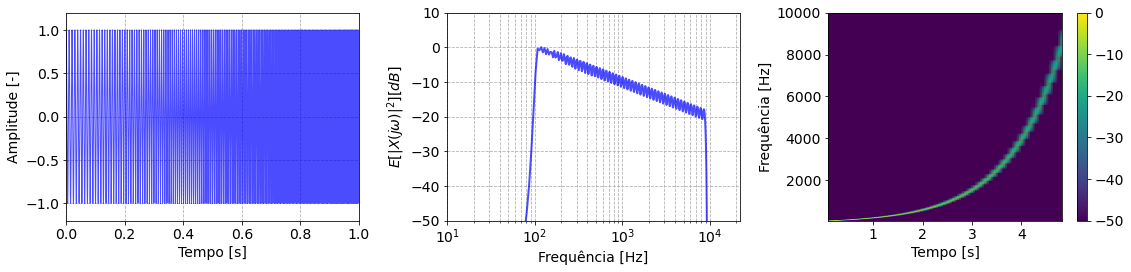

In [12]:
fs = 44100
time = np.arange(0, 5, 1/fs)
# sinal
xt = signal.chirp(time, 100, time[-1], 10000, method='logarithmic') #method: 'logarithmic' or 'linear'

# plot
plot_signal(xt, fs=fs, t_max = 1)

ipd.Audio(xt, rate=fs) # load a NumPy array

# Ruído branco

O ruído branco é um sinal gerado a partir da amostragem de uma uma distribuição normal, dada por:

\begin{equation}
p(t) = \mathcal{N}(\mu_x, \sigma_x) = \frac{1}{\sqrt{2\pi}\sigma_x}\mathrm{e}^{-\frac{1}{2\sigma_x^2}(t-\mu_x)^2}
\end{equation}
em que $\mu_x$ é o valor médio do sinal e $\sigma_{x}$ é o desvio padrão (ou valor RMS do sinal).

A cada instante de tempo $t$, nós sorteamos um valor da distribuição normal.

Note que:

- a magnitude ***média*** do espectro é plana;
- diferente do sweep, todas as frequências ocorrem ao mesmo tempo. O espectograma mostra este aspecto, lembrando uma TV fora do ar;
- o sinal é aleatório (ou pseudo-aleatório). Sem um ***seed*** cada geração levará a um sinal diferente. As características espectrais ***média***, no entanto se mantêm.

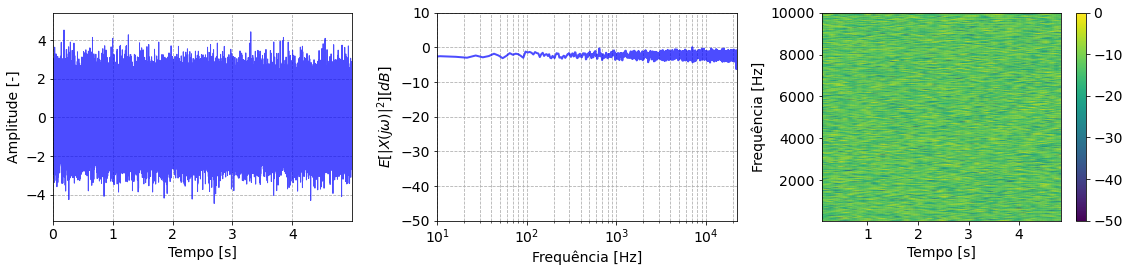

In [15]:
fs = 44100
time = np.arange(0,5, 1/fs)
# sinal
mu_x = 0
sigma_x = 1.0
xt = np.random.normal(loc = mu_x, scale = sigma_x, size=len(time))

# plot
plot_signal(xt, fs=fs, t_max = time[-1])

ipd.Audio(xt, rate=fs) # load a NumPy array


# Ruído rosa

Ruídos que possuem alguma ***cor*** são ruídos aleatórios (em geral) mas com características espectrais diferentes do ruído branco.

Os ruído que possuem alguma são aqueles em que a ***densidade espectral de potência*** ($S(f)$ $\equiv \|X(f)\|^2$) do sinal varia com a frequência da seguinte forma:

\begin{equation}
S(f) \propto \frac{1}{f^\beta}
\end{equation}

No caso do ruído rosa, $\beta = 1$ e a densidade espectral de potência decai 3dB por oitava. 

Não existe uma forma única de implementar um ruído rosa e a apresentada aqui é uma versão simplificada da encontrada no repositório https://github.com/felixpatzelt/colorednoise. Neste caso, geramos um espectro complexo a partir de amostras aleatórias de uma distribuição normal. Cada componente de frequência possui um desvio padrão que diminui de $1/f^\beta$ com o aumento da frequência. Finalmente, tomamos a IFFT para ter o sinal no domínio do tempo. Este procedimento implica que o valor RMS do sinal (seu desvio padrão) não é constante com o tempo. 

Note que:

- a magnitude ***média*** do espectro decai com a frequência;
- todas as frequências ocorrem ao mesmo tempo. O espectograma mostra este aspecto, mas note a diminuição da magnitude à medida que a frequência aumenta;
- o sinal é aleatório (ou pseudo-aleatório). Sem um ***seed*** cada geração levará a um sinal diferente. As características espectrais ***média***, no entanto se mantêm.

Você pode tentar outros valores de $\beta$. Valores maiores que $1$ implicam num decaimento mais abrupto de $S(f)$, o que concentra mais energia nas baixas frequências (ruídos vermelhos, marrons, etc). Valores menores que $0$ implicam num aumento $S(f)$ com a frequência, o que concentra mais energia nas altas frequências (ruído azul, etc). 

In [16]:
def pink_noise(N = 2**18, beta = 1, fs = 44100):
    """ Computes pink noise
    
    note: I did not tested for beta>1
    
    Parameters:
    ----------------------
    N : int
        number of samples in the signal
    beta : int
        exponent. For pink noise, beta = 1 (default)
    fs : int
        sampling frequency
    """
    # Calculate normalized frequencies - half vector (0 - fs/2)/fs
    f = np.linspace(0, (N-1)*(fs/2)/N, int(N/2))/fs
    size = len(f)
    # Build scaling factors for all frequencies
    s_scale = f
    s_scale[0] = f[1]
    s_scale = s_scale**(-beta/2)
    # Calculate theoretical output standard deviation  - scale the signal back
    sigma = 2*np.sqrt(np.sum(s_scale**2))/N
    # Generate scaled random power + phase
    sr = np.random.normal(scale=s_scale, size=size)
    si = np.random.normal(scale=s_scale, size=size)
    # Regardless of signal length, the DC component must be real
    si[0] = 0
    # Combine power + corrected phase to Fourier components
    s  = sr + 1j * si
    # Transform to real time series & scale to unit variance
    xt = np.real(np.fft.ifft(s, n = N)) / sigma
    time = np.linspace(0, (len(xt)-1)/fs, len(xt))
    return time, xt

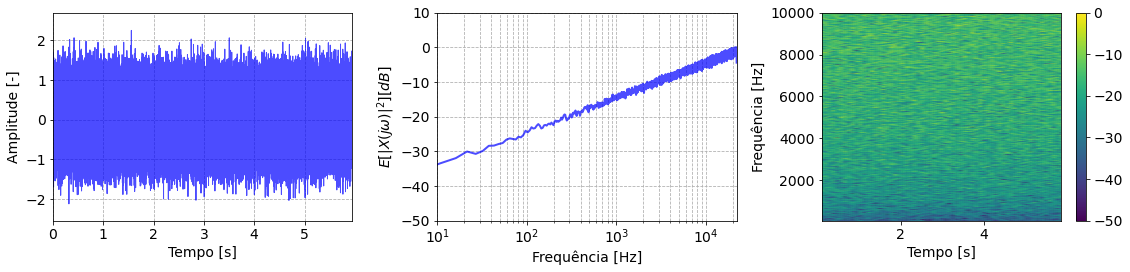

In [19]:
time, xt = pink_noise(N = 2**18, beta = -1, fs=44100)

plot_signal(xt, fs=fs, t_max = time[-1])
ipd.Audio(xt, rate=fs) # load a NumPy array

# MLS

A sigla MLS vem de Maximum Length Sequence. Este é um sinal determinístico e binário (composto de uma sequência de $+1$ e $-1$). O sinal foi muito utilizado na medição de resposta ao impulso na década de 1990, devido a algumas propriedades matemáticas, que facilitavam os cálculos de FFT.

Note que:

- a magnitude ***média*** do espectro é plana;
- diferente do sweep, todas as frequências ocorrem ao mesmo tempo. O espectograma mostra este aspecto, lembrando uma TV fora do ar;
- o sinal é determinístico.

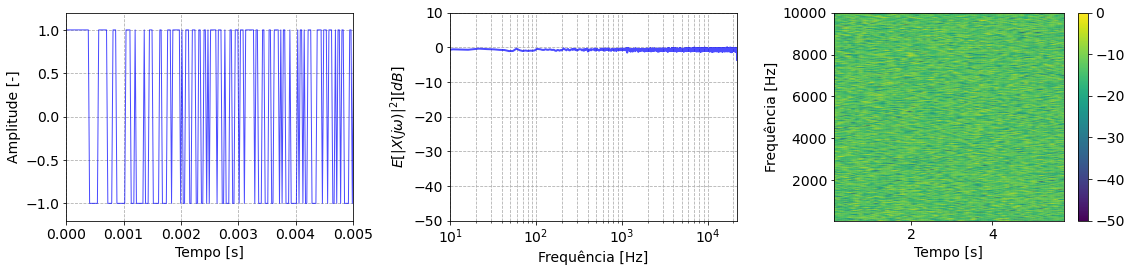

In [20]:
fs = 44100
order = 18
# sinal
xt = 2*(signal.max_len_seq(order)[0]-0.5)

# plot
plot_signal(xt, fs=fs, t_max = 0.005)

ipd.Audio(xt, rate=fs) # load a NumPy array